In [14]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load data


In [15]:
video = cv2.VideoCapture(os.path.join("..", "data", "raw", "train", "1606b0e6_0.mp4"))
df = pd.read_csv(os.path.join("..", "data", "raw", "train.csv"))

In [16]:
df = df[~df["event"].isin(["start", "end"])]
df

,video_id,time,event,event_attributes
1,1606b0e6_0,201.150,challenge,['ball_action_forced']
4,1606b0e6_0,210.870,challenge,['opponent_dispossessed']
7,1606b0e6_0,219.230,throwin,['pass']
10,1606b0e6_0,224.430,play,"['pass', 'openplay']"
13,1606b0e6_0,229.390,play,"['pass', 'openplay']"
...,...,...,...,...
11206,ecf251d4_0,3041.347,play,"['pass', 'openplay']"
11209,ecf251d4_0,3050.347,play,"['pass', 'openplay']"
11210,ecf251d4_0,3053.067,play,"['pass', 'openplay']"
11213,ecf251d4_0,3056.587,challenge,['opponent_dispossessed']


In [38]:
a1 = df['time'].to_numpy()[:-1]
a2 = df['time'].to_numpy()[1:]

np.abs(a2 - a1).min()

0.7199999999997999

In [50]:
video.set(cv2.CAP_PROP_POS_MSEC, 201.150000 * 1000)

ret, frame = video.read()
video.get(cv2.CAP_PROP_POS_FRAMES)

5030.0

In [51]:
fps = video.get(cv2.CAP_PROP_FPS)
frame_number = int(fps * 201.150000)
video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

ret, frame2 = video.read()
video.get(cv2.CAP_PROP_POS_FRAMES)

5029.0

In [21]:
from src.data.processing import extract_frames, save_frames

frames = extract_frames(video, 201, 16)

In [22]:
save_frames(frames, 32, '../data/processed/test.mp4')

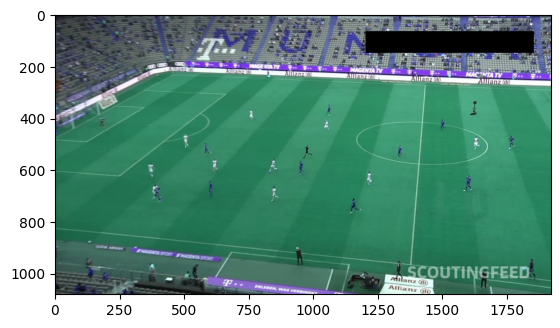

In [48]:
plt.imshow(frame)

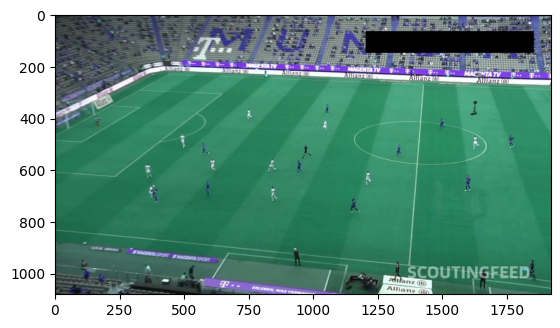

In [49]:
plt.imshow(frame2)

# Explore videos

In [9]:
import torchvision
import os
# torchvision.set_video_backend("video_reader")

video_path = os.path.join("..", "data", "raw", "train", "1606b0e6_0.mp4")

In [10]:
video = torchvision.io.VideoReader(video_path, 'video')

AttributeError: 'ImportError' object has no attribute 'open'

# Create labels


In [35]:
from typing import Literal


def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sig, 2.0)))


def create_label(
    frame_number: int,
    window_size: int,
    action: Literal["play", "challenge", "throwin", "nothing"],
) -> dict[str, np.ndarray]:
    values = np.array(range(window_size))
    values = gaussian(values, frame_number, 2.5)
    label = {
        "play": np.zeros(window_size),
        "challenge": np.zeros(window_size),
        "throwin": np.zeros(window_size),
    }

    if action != "nothing":
        label[action] = values

    return label


np.array(list(create_label(15, 16, "challenge").values()))

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.52299797e-08, 1.54975314e-07, 1.34381228e-06, 9.92950431e-06,
        6.25215038e-05, 3.35462628e-04, 1.53381068e-03, 5.97602290e-03,
        1.98410947e-02, 5.61347628e-02, 1.35335283e-01, 2.78037300e-01,
        4.86752256e-01, 7.26149037e-01, 9.23116346e-01, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

# Create data loaders

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd


class DFLDataset(Dataset):
    def __init__(self, annotations_file: str, video_dir: str):
        df = pd.read_csv(annotations_file)
        self.video_labels = df[~df["event"].isin(["start", "end"])]

In [26]:
arr = np.array([1, 2, 3, 4, 5])
arr[np.array([True, False, True, True, True])]

array([1, 3, 4, 5])

In [53]:
b = np.array([True] * 10)
b[5] = False
np.concatenate([arr, b])

array([1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [44]:
import random


def mark_frames(mask: np.ndarray, frame: int, window_size: int) -> np.ndarray:
    new_mask = mask.copy()
    start_frame = max(0, frame - window_size // 2)
    end_frame = frame + window_size // 2
    new_mask[start_frame : end_frame + 1] = False
    return new_mask


def sample_negative(
    sample_size: int, taken_frames: np.ndarray, window_size: int, frames_num: int
) -> np.ndarray:
    frames = np.array(list(range(frames_num)))
    available_frames_mask = np.array([True] * frames_num)

    # First mark all taken frames as taken
    for frame in taken_frames:
        available_frames_mask = mark_frames(
            available_frames_mask, frame=frame, window_size=window_size
        )

    available_frames = frames[available_frames_mask]
    # Filter out some more frames to prevent too similar clips
    available_frames = available_frames[:: window_size // 4]
    sampled_frames = np.random.choice(available_frames, sample_size, replace=False)

    return sampled_frames

In [45]:
taken_frames = np.array([5, 15])

sample_negative(4000, taken_frames, 6, 10000000)

array([3019336, 9692831, 5634308, ..., 3167741, 4640847, 8099103])